In [ ]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 19kB/s 
     |████████████████████████████████| 460kB 57.4MB/s 
     |████████████████████████████████| 3.0MB 56.3MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
!nvidia-smi

Wed Aug  5 03:29:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten,Concatenate
from keras.layers import Layer, Reshape, BatchNormalization, Activation, Input
from keras.models import Model
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras.utils import  to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import random

Using TensorFlow backend.


# First, we import the required libraries
## In this section, we initialize a set of constants

**Latentdim = 100**  
**Batchsize = 30**


In [ ]:
latent_dim=100
image_size=32
image_shape=(image_size,image_size,3)

gen_filters=[256,128,64,3]
gen_strides=[2,2,2,2]

dis_filters=[64,128,256,512]
dis_strides=[2,2,2,2]
kernel_size=5
strides=2
#alpha=0.2

batch_size=30

# dis_lr=2e-4
# dis_decay=6e-8
dis_optimizer=tf.keras.optimizers.Adam(lr=1e-3,beta_1=0.5)

# adv_lr=dis_lr*0.5
# adv_decay=dis_decay*0.5
adv_optimizer=Adam(lr=1e-4,beta_1=0.5)

save_intervals=1000
train_steps=10000
log_print_steps=3
test_size=100

'''load dataset'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = (x_train.astype('float32') - 127.5) / 127.5, (x_test.astype('float32') - 127.5) / 127.5
y_train=to_categorical(y_train)

print(x_train.shape, x_test.shape)
print(y_train.shape)
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
170500096/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.5372549  -0.5137255  -0.5058824 ]
  [-0.6627451  -0.6392157  -0.64705884]
  [-0.60784316 -0.62352943 -0.6627451 ]
  ...
  [ 0.23921569  0.03529412 -0.15294118]
  [ 0.19215687 -0.01960784 -0.2       ]
  [ 0.16078432 -0.02745098 -0.19215687]]

 [[-0.8745098  -0.84313726 -0.84313726]
  [-1.         -1.         -1.        ]
  [-0.85882354 -0.9372549  -1.        ]
  ...
  [-0.03529412 -0.30980393 -0.5686275 ]
  [-0.06666667 -0.34901962 -0.60784316]
  [-0.04313726 -0.31764707 -0.5529412 ]]

 [[-0.8039216  -0.8117647  -0.8352941 ]
  [-0.8745098  -0.94509804 -1.        ]
  [-0.6156863  -0.7882353  -0.9372549 ]
  ...
  [-0.07450981 -0.34117648 -0.60784316]
  [-0.05882353 -0.34117648 -0.60784316]
  [-0.14509805 -0.42745098 -0.67058825]]

 ...

 [[ 0.6313726   0.33333334 -0.24705882]
  [ 0.5764706   0.2        -0.73333335]
  [ 0.5529412   0.2627451  -0.79607844]
  ...
  [ 0.25490198  0.04313726 -0.4509804 ]
  [-0.56078434 -0.75686276 -0.94509804]
  [-0.58431375 -0.73333335 -0.84313726]]

 [

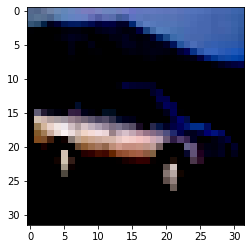

In [ ]:

plt.imshow(x_train[4])
print(x_train[0])

In [ ]:
os.makedirs('images', exist_ok=True)

# Generator

Now we need to define the required functions
The first function is the one that creates the generator. In this part of the network, the inputs are a 10-dimensional vector to specify the label and a vector with the dimensions we defined as 100.
In the next layer, these two vectors are concatenated. In the following layer, we have a fully connected layer with dimensions of 22512.

In the next layer, we have a convolution that transforms the image into 2x2 with a depth of 512 filters (the number of these filters is taken from the vector initially defined).

Next layer: 4x4x256.

Next layer: 8x8x128.

Next layer: 16x16x64.

And the next layer is the output, which will be a color image with dimensions of 32x32x3.

Initially, since the last layer of the generator is a hyperbolic tangent, the images are mapped to values between -1 and 1.


In [ ]:
def bn_relu(x):
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  return x

In [ ]:
def build_generator(image_size=32):
  filters=gen_filters
  z_inputs=Input(shape=(latent_dim,),name='gen_z_inputs')
  label_inputs=Input(shape=(10,),name='gen_label_inputs')
  x=Concatenate([z_inputs,label_inputs])#110

  image_resize=2

  x=Dense(image_resize*image_resize*512)(x)
  x=Reshape((image_resize,image_resize,512))(x)

  for strides,filter in zip(gen_strides,filters):
    x=bn_relu(x)
    x=Conv2DTranspose(filters=filter,kernel_size=kernel_size,padding='same',strides=strides, use_bias=False)(x)
  outputs=Activation('tanh',name='Tanh')(x)
  model=Model([z_inputs,label_inputs],outputs,name='generator')
  print('\n \n Gen model')
  model.summary()
  plot_model(model,to_file='generator.png',show_shapes=True)
  return model

In [ ]:
gen=build_generator()

# Discriminator

In the next function, the discriminator is built: This part of the network takes an image as input and outputs a binary value (0 or 1) to determine whether the image is real or fake, and also classifies which category it belongs to.

So the input: 32x32x3

Next layer: 64x16x16

Next layer: 128x8x8

Next layer: 256x4x4

Next layer: 512x2x2

After this, the layer passes through a flattening layer, and the input is split into two parts, each reaching one of the outputs.
In this case, two loss functions are used for our two outputs.



In [ ]:
def build_discriminator():
  dis_inputs=Input(shape=image_shape,name='dis_inputs')
  x=dis_inputs
  for strides,filter in zip(dis_strides,dis_filters):
    x=Conv2D(filters=filter,kernel_size=kernel_size,padding='same',strides=strides)(x)
    x=BatchNormalization()(x)
    x= LeakyReLU()(x)
  y=Flatten()(x)

  x=Dense(1)(y)
  rf_outputs=Activation('sigmoid',name='sigmoid')(x)

  c=Dense(256)(y)
  c=Dense(128)(c)
  c=Dense(10)(c)
  label_outputs=Activation('softmax',name='softmax')(c)

  model=Model(dis_inputs,[rf_outputs,label_outputs], name='discriminator')
  model.compile(Adam(lr=1e-3,beta_1=0.5),loss=['binary_crossentropy','categorical_crossentropy'],metrics=['acc'])
  print('\n \n Dis model')
  model.summary()
  #plot_model(model,to_file='discriminator.png',show_shapes=True)
  return model


In [ ]:
dis=build_discriminator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

 
 Dis model
Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dis_inputs (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  3584        dis_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 32, 32, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, 32, 32, 128)  0           batch_normal

# Training mechanism
In this network, the training mechanism works as follows: 
In the first stage, a set of real data along with their labels (as the target) is fed to the discriminator so that it learns to recognize them as real. In the next stage, the generator's generated images, along with the labels they were supposed to produce (as the target) and were given as input, are fed to the discriminator so that it learns to recognize them as fake.

In the next stage, the generator needs to be trained in such a way that it produces outputs and learns to generate outputs that the discriminator recognizes as real.

To do this, we need a network that includes both parts, but only trains the generator part.


In [ ]:
def build_adv(gen,dis):

  gen_z_inputs=Input(shape=(latent_dim,),name='gen_z_inputs')
  gen_label_inputs=Input(shape=(10,),name='gen_label_inputs')


  fake_images = gen([gen_z_inputs, gen_label_inputs])
  
  adv_inputs=[gen_z_inputs,gen_label_inputs]
  adv_outputs=dis(fake_images)
  

  adv_inputs=[gen_z_inputs,gen_label_inputs]
  adv=Model(adv_inputs,adv_outputs,name='adverserial')
  

  adv.compile(Adam(lr=0.0004,beta_1=0.5),loss=['binary_crossentropy','categorical_crossentropy'],metrics=['binary_accuracy','categorical_accuracy'])
  adv.summary
  return adv


In [ ]:
dis.trainable = False 
adv=build_adv(gen,dis)
adv.summary()

Model: "adverserial"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gen_z_inputs (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
gen_label_inputs (InputLayer)   (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    2970755     gen_z_inputs[0][0]               
                                                                 gen_label_inputs[0][0]           
__________________________________________________________________________________________________
discriminator (Model)           [(None, 1), (None, 1 1353227     generator[1][0]        

As mentioned above, now the training must be performed for the desired number of epochs, processing all the data in batches of 30 in each epoch.
In each step, the discriminator is trained once, and the generator is trained once with random labels and noise. Every 10 epochs, the output images from the generator are printed to track progress.



epoch = 1/100, disLoss=1.339, genLoss=1.424                                                                                                     


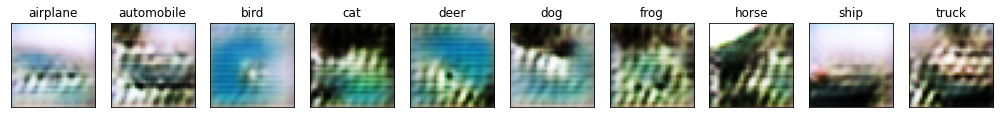

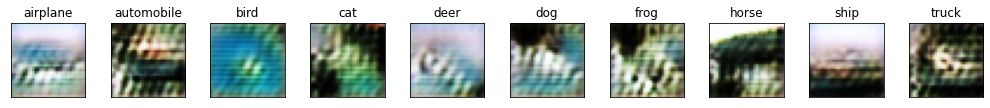

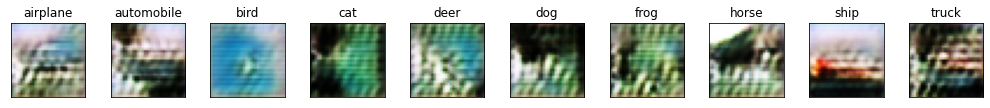

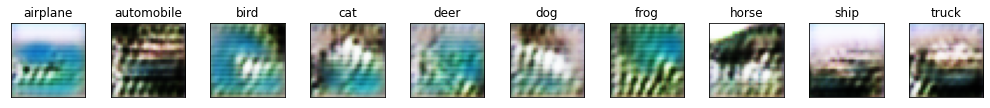

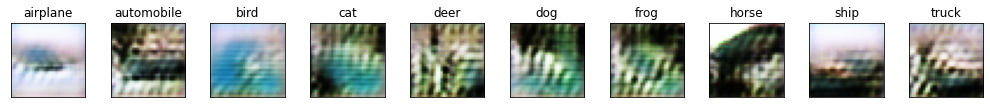

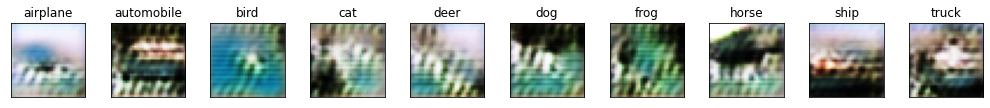

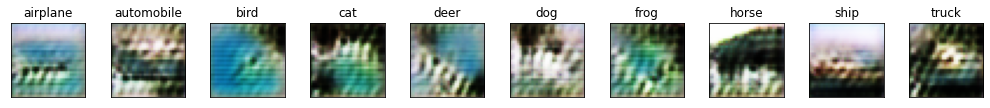

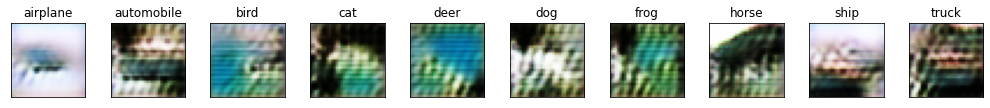

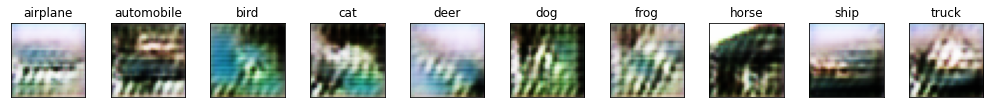

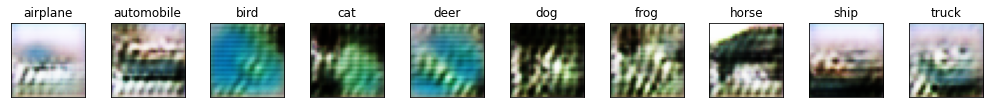

epoch = 2/100, disLoss=1.129, genLoss=0.815                                                                                                     
epoch = 3/100, disLoss=0.893, genLoss=0.812                                                                                                     
epoch = 4/100, disLoss=1.083, genLoss=2.425                                                                                                     
epoch = 5/100, disLoss=0.866, genLoss=1.954                                                                                                     
epoch = 6/100, disLoss=0.870, genLoss=0.617                                                                                                     
epoch = 7/100, disLoss=0.737, genLoss=2.547                                                                                                     
epoch = 8/100, disLoss=1.257, genLoss=2.049                                                                                       

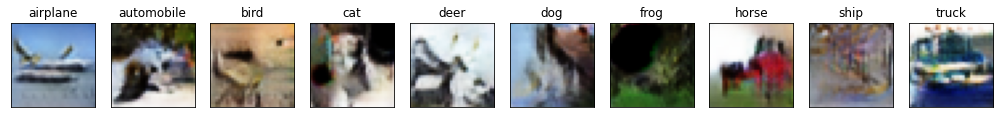

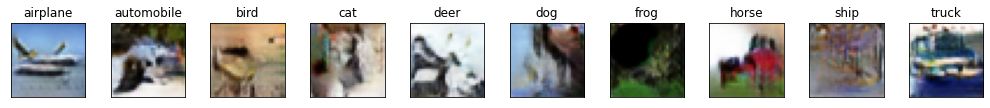

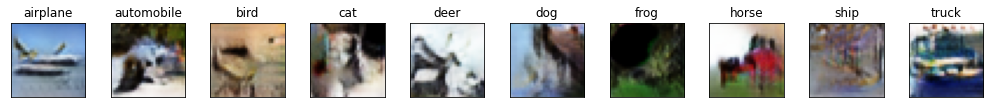

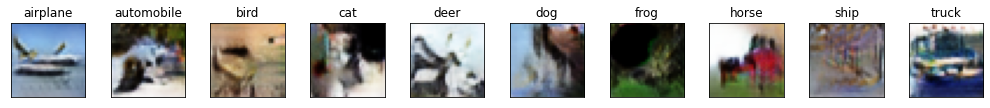

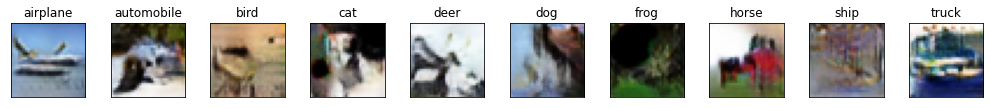

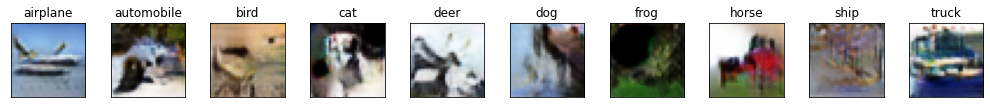

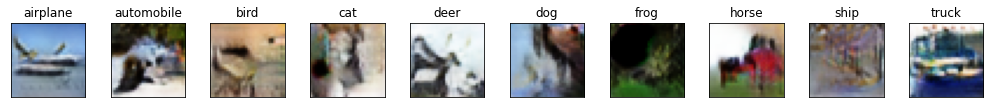

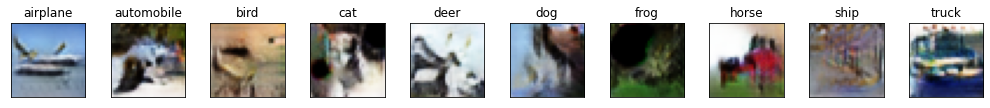

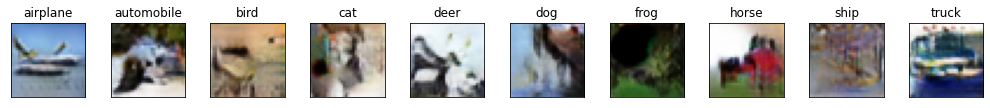

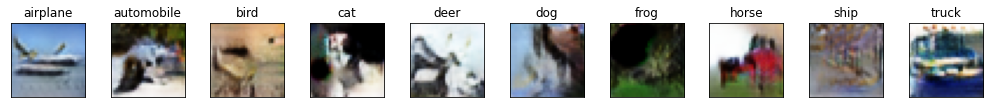

epoch = 12/100, disLoss=0.933, genLoss=1.630                                                                                                     
epoch = 13/100, disLoss=0.606, genLoss=1.156                                                                                                     
epoch = 14/100, disLoss=0.688, genLoss=0.744                                                                                                     
epoch = 15/100, disLoss=0.773, genLoss=1.203                                                                                                     
epoch = 16/100, disLoss=0.779, genLoss=0.915                                                                                                     
epoch = 17/100, disLoss=0.874, genLoss=1.299                                                                                                     
epoch = 18/100, disLoss=0.667, genLoss=0.704                                                                                

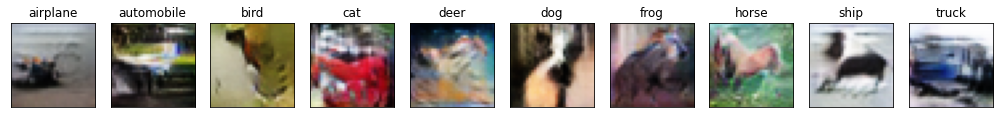

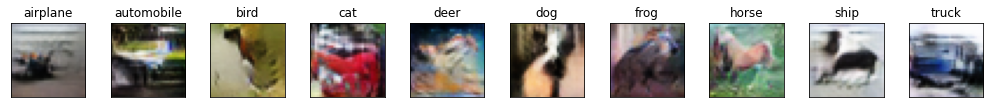

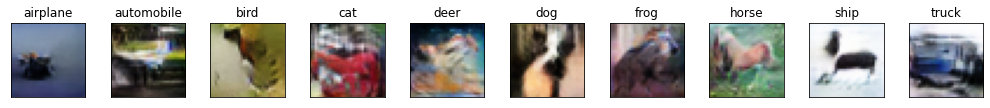

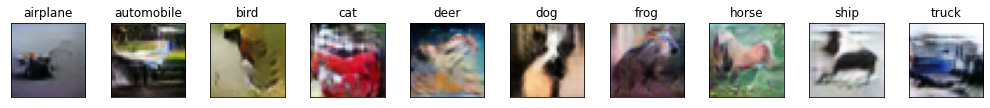

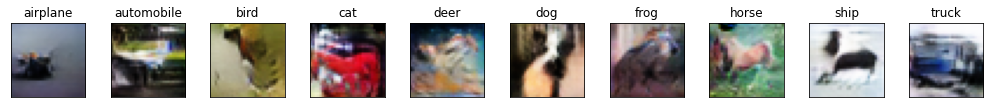

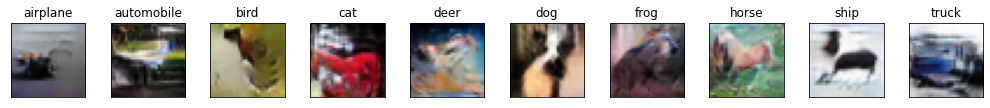

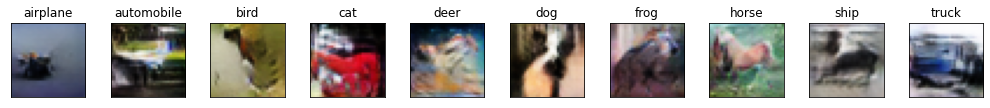

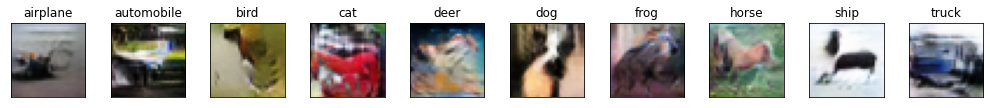

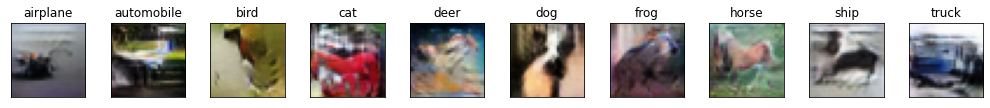

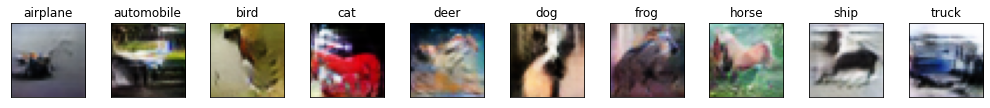

epoch = 22/100, disLoss=0.891, genLoss=1.077                                                                                                     
epoch = 23/100, disLoss=0.715, genLoss=1.033                                                                                                     
epoch = 24/100, disLoss=0.868, genLoss=0.789                                                                                                     
epoch = 25/100, disLoss=0.877, genLoss=1.317                                                                                                     
epoch = 26/100, disLoss=0.935, genLoss=1.848                                                                                                     
epoch = 27/100, disLoss=0.559, genLoss=0.737                                                                                                     
epoch = 28/100, disLoss=0.402, genLoss=0.332                                                                                

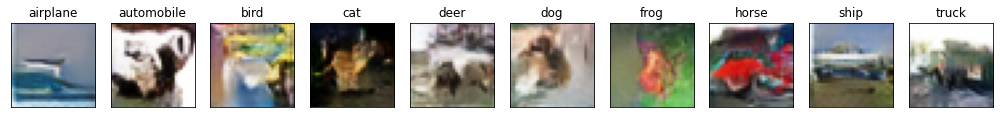

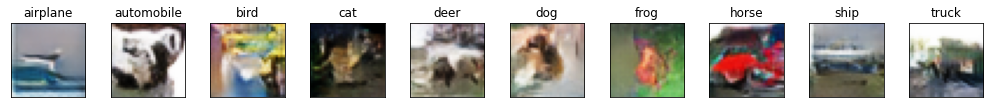

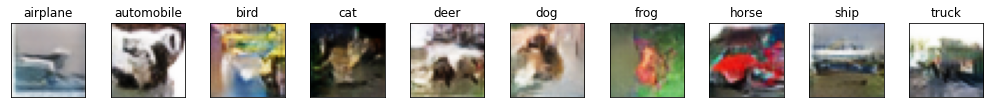

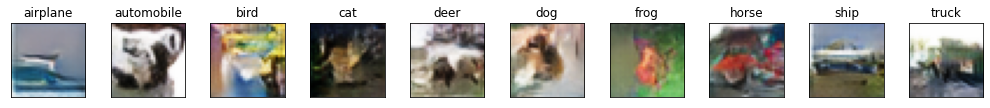

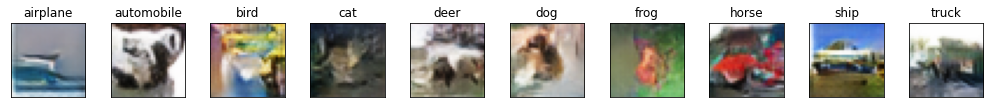

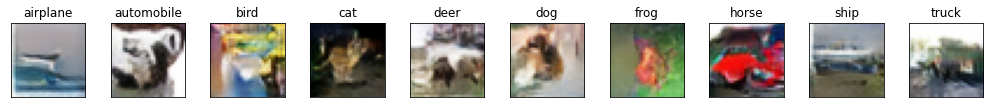

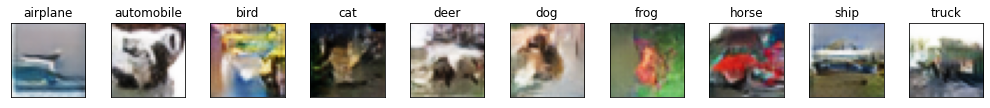

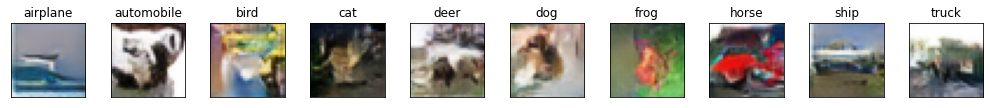

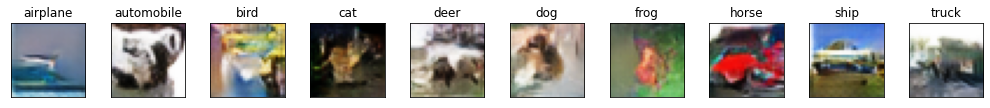

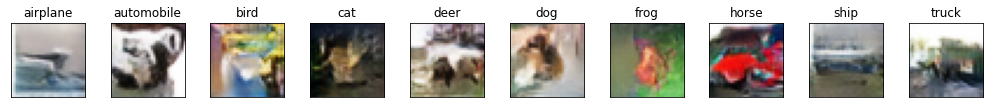

epoch = 32/100, disLoss=0.618, genLoss=0.794                                                                                                     
epoch = 33/100, disLoss=0.641, genLoss=1.149                                                                                                     
epoch = 34/100, disLoss=0.775, genLoss=0.519                                                                                                     
epoch = 35/100, disLoss=0.622, genLoss=0.590                                                                                                     
epoch = 36/100, disLoss=0.691, genLoss=0.818                                                                                                     
epoch = 37/100, disLoss=0.462, genLoss=1.101                                                                                                     
epoch = 38/100, disLoss=0.705, genLoss=0.558                                                                                

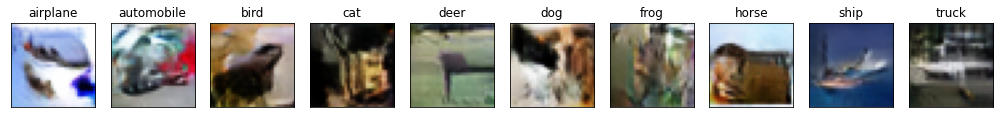

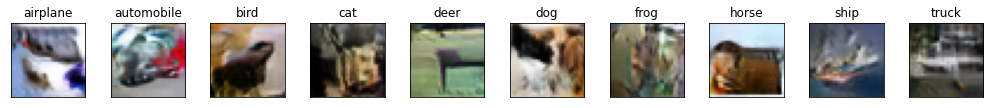

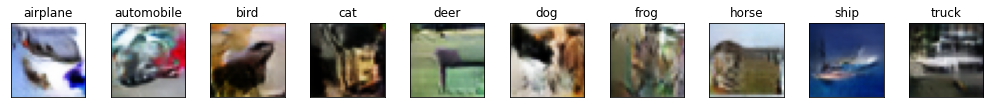

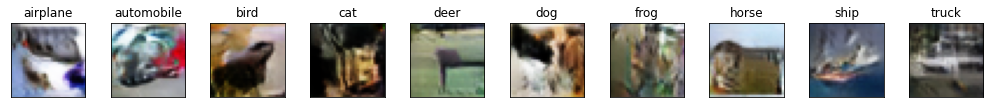

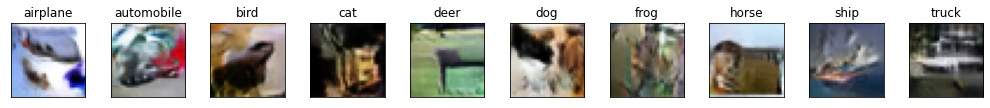

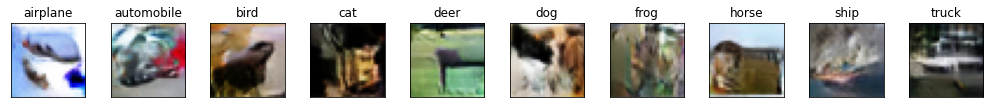

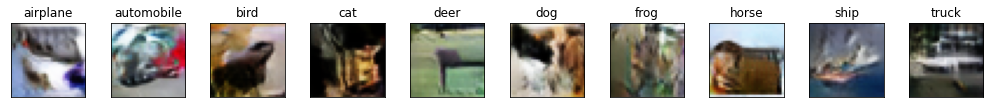

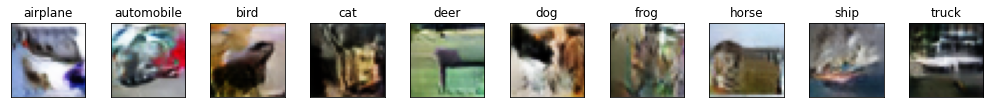

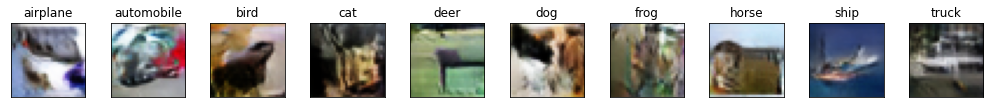

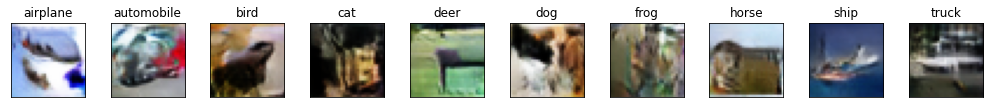

epoch = 42/100, disLoss=0.491, genLoss=1.332                                                                                                     
epoch = 43/100, disLoss=0.806, genLoss=0.656                                                                                                     
epoch = 44/100, disLoss=0.502, genLoss=1.041                                                                                                     
epoch = 45/100, disLoss=0.883, genLoss=0.633                                                                                                     
epoch = 46/100, disLoss=0.555, genLoss=0.822                                                                                                     


KeyboardInterrupt: ignored

In [ ]:
disLoss = []
genLoss = []
EPOCHS=100
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
for e in range(EPOCHS + 1):
    for i in range(len(x_train) // batch_size):


        dis.trainable = True
        
        x_batch = x_train[i*batch_size:(i+1)*batch_size]
        real_one_hot_labels =y_train[i*batch_size:(i+1)*batch_size]
        # print(real_one_hot_labels.shape)
        # print(real.shape)
        # print(y_train.shape)
        
      #generate fake
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        x_fake = gen.predict_on_batch([z, random_labels])

        #train dis
        disLoss_real = dis.train_on_batch(x_batch,[real * 0.9,real_one_hot_labels])
        disLoss_fake = dis.train_on_batch(x_fake, [fake,random_labels])
        disLoss_batch = 0.5 * (disLoss_real[0] + disLoss_fake[0])
        

        dis.trainable = False
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        genLoss_batch = adv.train_on_batch([z, random_labels], [real,random_labels]) 
   

    disLoss.append(disLoss_batch)
    genLoss.append(genLoss_batch[0])
    print('epoch = %d/%d, disLoss=%.3f, genLoss=%.3f' % (e + 1, EPOCHS, disLoss[-1], genLoss[-1]), 100*' ')

   
    if e % 10 == 0:
      te=[]
      c=0
      for k in range (100):  
        samples = 1
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.eye(10)[np.arange(batch_size)%10]
        label=labels[k].reshape(1,10)
        te_fake = gen.predict([z, label])
        te_fake = np.clip(te_fake, -1, 1)
        te_fake = (te_fake + 1) * 127
        te_fake = np.round(te_fake).astype('uint8')
        te.append(te_fake)
        c+=1
        if c==10:
          c=0
      te=np.array(te)
      te=te.reshape(100,32,32,3)

      fig = plt.figure(figsize=(14,14))
      for i in range(10):
        for j in range(10):
          plt.subplot(10, 10, i*10+j+1, xticks=[], yticks=[])
          plt.imshow(te[i*10+j+1])
          plt.title(class_names[j])

      plt.tight_layout()
      plt.show()

In [ ]:
print(z.shape)
print(label.shape)
print(te.shape)

(1, 100)
(1, 10)
(100, 1, 32, 32, 3)


In [ ]:
labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
print(labels.shape)

(10, 10)


In [ ]:
print(te_fake.shape)
print(m)
print(labels)
print(np.eye(10)[np.arange(batch_size)%10])

(10, 32, 32, 3)
0
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0

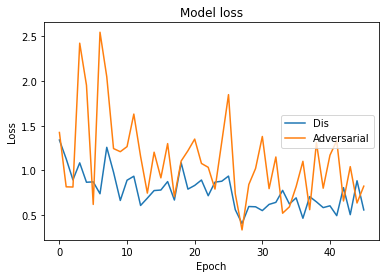

In [ ]:
# plotting the metrics
plt.plot(disLoss)
plt.plot(genLoss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dis', 'Adversarial'], loc='center right')
plt.show()